# 8-1. 프로젝트: 뉴스기사 요약해보기


In [2]:
import nltk
import tensorflow
import summa
import pandas as pd

#summa==1.2.0
print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)


2025-02-09 18:54:26.636853: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-09 18:54:27.411519: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


3.7
2.13.0
2.0.3


Step 1. 데이터 수집하기

데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")

('news_summary_more.csv', <http.client.HTTPMessage at 0x7f34f41f3a00>)

In [4]:
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.reset_index()
data.head(10)

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...
6,"India get all out for 92, their lowest ODI tot...",India recorded their lowest ODI total in New Z...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...
8,Called PM Modi 'sir' 10 times to satisfy his e...,Andhra Pradesh CM N Chandrababu Naidu has said...
9,"Cong wins Ramgarh bypoll in Rajasthan, takes t...",Congress candidate Shafia Zubair won the Ramga...


Step 2. 데이터 전처리하기 (추상적 요약)

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 

만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

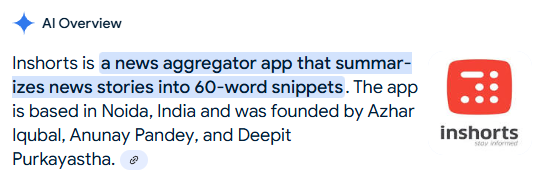

    - 이 데이터셋은 인쇼츠라는 인도 뉴스 플렛폼으로 다양한 주제로 뉴스를 작성하는 것을 확인 할 수 있음
    - 데이터셋에 전반적으로 India 라는 단어가 많이 나올 것으로 예상 => 확인 후 빈도가 너무 많다면 불용어로 제거하는 것이 요약 성능을 높일 것으로 추정

In [5]:
nltk.download('stopwords')

from nltk.corpus import stopwords

stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/cho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [7]:
len(data)

98401

In [8]:
# 중복인 열의 데이터를 확인하기
duplicate_indices = []

unique_headlines = data['headlines'].unique()

for headline in unique_headlines[:10000]:
    indices = data[data['headlines'] == headline].index.tolist()
    if len(indices) > 1:
        print(f"중복된 헤드라인: {headline}")
        print(f"중복된 행의 인덱스: {indices}")
        duplicate_indices.extend(indices)
        print()

중복된 헤드라인: Isha Ambani features on February cover of Vogue magazine
중복된 행의 인덱스: [23, 3292]

중복된 헤드라인: Indian Oil looking for annual deal to buy crude from US
중복된 행의 인덱스: [24, 3293]

중복된 헤드라인: Pacer once took 7 wickets for just 1 run in 32 balls in a Test
중복된 행의 인덱스: [25, 36907]

중복된 헤드라인: Mughal Gardens to open for public from February 6
중복된 행의 인덱스: [416, 49195]

중복된 헤드라인: Longest Test innings was longer than 10 football games
중복된 행의 인덱스: [1017, 51012]

중복된 헤드라인: Suzuki Connect helps you connect to your car seamlessly
중복된 행의 인덱스: [1092, 36908]

중복된 헤드라인: AB de Villiers hit ODIs' fastest hundred in 40 minutes
중복된 행의 인덱스: [1576, 51680]

중복된 헤드라인: Indian spinner once bowled record 21 maiden overs in a row
중복된 행의 인덱스: [2461, 40873, 71892]

중복된 헤드라인: What led to the birth of One Day International cricket?
중복된 행의 인덱스: [3453, 53704]

중복된 헤드라인: Captain once dropped himself, replacement broke his ribs
중복된 행의 인덱스: [3587, 53731]

중복된 헤드라인: DMRC reserves 1st coach in all lines, except Red, for wome

In [9]:
duplicate_data = data.loc[duplicate_indices]
duplicate_data

,headlines,text
23,Isha Ambani features on February cover of Vogu...,Reliance Industries' Chairman Mukesh Ambani's ...
3292,Isha Ambani features on February cover of Vogu...,Reliance Industries' Chairman Mukesh Ambani's ...
24,Indian Oil looking for annual deal to buy crud...,Indian Oil Corporation on Wednesday said it's ...
3293,Indian Oil looking for annual deal to buy crud...,Indian Oil Corporation on Wednesday said it's ...
25,Pacer once took 7 wickets for just 1 run in 32...,Former Windies fast bowler Curtly Ambrose dism...
36907,Pacer once took 7 wickets for just 1 run in 32...,"Former Windies' fast bowler Curtly Ambrose, wh..."
416,Mughal Gardens to open for public from February 6,The Rashtrapati Bhavan's Mughal Gardens will b...
49195,Mughal Gardens to open for public from February 6,The Rashtrapati Bhavan's Mughal Gardens will b...
1017,Longest Test innings was longer than 10 footba...,Former Pakistani cricketer Hanif Mohammad batt...
51012,Longest Test innings was longer than 10 footba...,Former Pakistani cricketer Hanif Mohammad batt...


In [10]:
#헤드라인이 겹치더라도 text가 항상 겹치는 것은 아님을 확인
# => text기준으로 drop
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [11]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [12]:
print(str(data['text']))

0        Saurav Kant, an alumnus of upGrad and IIIT-B's...
1        Kunal Shah's credit card bill payment platform...
2        New Zealand defeated India by 8 wickets in the...
3        With Aegon Life iTerm Insurance plan, customer...
4        Speaking about the sexual harassment allegatio...
                               ...                        
98396    A CRPF jawan was on Tuesday axed to death with...
98397    'Uff Yeh', the first song from the Sonakshi Si...
98398    According to reports, a new version of the 199...
98399    A new music video shows rapper Snoop Dogg aimi...
98400    Madhesi Morcha, an alliance of seven political...
Name: text, Length: 98360, dtype: object


In [13]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [14]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [15]:
import re

# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [16]:
# 전체 text 데이터에 대한 전처리
clean_text = []

data = data.reset_index(drop=True)


for idx in range(len(data)):
    text = data.loc[idx,'text']
    text = preprocess_sentence(text)
    clean_text.append(text)

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

# 전체 headlines 데이터에 대한 전처리 (불용어 미처리)
clean_summary = []

for idx in range(len(data)):
    text = data.loc[idx,'headlines']
    text = preprocess_sentence(text, False)
    clean_summary.append(text)


print("Summary 전처리 후 결과: ", clean_summary[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [25]:
#sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환 => 이 부분으로 90%,
# 12-match 같은 표현이 사라지는 것을 확인, 의미가 너무 달라져 수정이 필요하다고 판단
pd.set_option("display.max_rows",None)
pd.set_option("display.max_colwidth",None)
display("Text 전처리 전 결과: ", data.loc[:5,'text'])
display("Summary 전처리 전 결과: ", data.loc[:5,'headlines'])

'Text 전처리 전 결과: '

0      Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
1                                  Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
2                     New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 c

'Summary 전처리 전 결과: '

0      upGrad learner switches to career in ML & Al with 90% salary hike
1           Delhi techie wins free food from Swiggy for one year on CRED
2       New Zealand end Rohit Sharma-led India's 12-match winning streak
3               Aegon life iTerm insurance plan helps customers save tax
4    Have known Hirani for yrs, what if MeToo claims are not true: Sonam
5      Rahat Fateh Ali Khan denies getting notice for smuggling currency
Name: headlines, dtype: object

In [30]:
# 데이터 전처리 함수 수정
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()  # 텍스트 소문자화
    sentence = re.sub(r'\([^)]*\)', '', sentence)  # 괄호로 닫힌 문자열 제거
    sentence = re.sub('"', '', sentence)  # 쌍따옴표 제거
    sentence = re.sub(r"'s\b", "", sentence)  # 소유격 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    
    # 영어 외 문자 제거 → 단어(숫자, 영문, 하이픈 포함)를 유지하는 방식으로 변경
    sentence = re.sub(r"[^a-zA-Z0-9\-%]", " ", sentence)  #숫자 영어를 제외한 표현은 띄어쓰기로 바꿈 (-,%은 제외 : 예.ai-driven과 같이 -이 들어갔을때의 의미가 있다고 생각)
    sentence = re.sub(r'\s+', ' ', sentence).strip()  # 불필요한 공백 정리
    
    # 불용어 제거
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if word not in stopwords.words('english') and len(word) > 1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    
    return tokens


In [31]:
# 다시 전처리 함수 적용
# 전체 text 데이터에 대한 전처리
clean_text = []

data = data.reset_index(drop=True)


for idx in range(len(data)):
    text = data.loc[idx,'text']
    text = preprocess_sentence(text)
    clean_text.append(text)

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

# 전체 headlines 데이터에 대한 전처리 (불용어 미처리)
clean_summary = []

for idx in range(len(data)):
    text = data.loc[idx,'headlines']
    text = preprocess_sentence(text, False)
    clean_summary.append(text)


print("Summary 전처리 후 결과: ", clean_summary[:5])
# Ã¢ÂÂ¹46,800^ 이 46 800 으로 바뀌는 등의 문제가 있지만 더 나은 방법이 떠오르지 않음
# 생각보다 불용어 제거로 인해 인터뷰 내용들이 많이 망가지는 것을 확인, 특히 not 이 불용어에 포함되어 있어
# not을 불용어에서 제거해야 된다고 판단

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit-b pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad 360-degree career support helped transition data scientist tech mahindra 90% salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending 2000 cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five-match odi series india lost international match rohit sharma captaincy 12 consecutive victories dating back march 2018 match witnessed india getting 92 seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save 46 800 taxes plan provides life cover age 1

In [32]:
stop_words = set(stopwords.words('english'))
stop_words.discard('no')
stop_words.discard('not')
stop_words.discard('nor')
print(stop_words)

{'few', 'have', 'his', 'there', 'between', 'off', 'theirs', 'you', 'this', 'doing', 'out', 'how', 'down', 'ma', 'than', 'being', 'been', 'further', 'be', 'hasn', 'the', 'yourself', 'aren', 'so', 'll', 'above', 'had', 'then', 'both', 'too', 'yours', 'it', 'while', 'does', 'yourselves', 'i', 'own', 'don', 'do', 'below', 'to', 'he', "it's", 'herself', 're', 'shouldn', 'by', 'on', 'at', "isn't", 'each', 'over', "didn't", 'in', 'some', 'himself', "shan't", 'won', 's', 'them', 'wasn', 'needn', 'those', "haven't", 'all', 'its', 'about', 'for', 'my', 'if', 'they', 'has', 'because', 'are', "doesn't", 'your', 'hers', 'after', 'with', "that'll", 'myself', "shouldn't", 'only', "mightn't", 'most', "she's", 'who', 'when', 'm', "wasn't", 'through', 'now', 'weren', "hadn't", "hasn't", 'will', 'during', 'or', 'but', 'wouldn', 'ain', "you're", 'me', 'hadn', 'why', 'him', 'mightn', 'very', 'whom', "should've", 'where', "won't", 'we', "you'll", 'that', 'didn', 'were', 'themselves', 'itself', 'of', 'our', 

In [33]:
# 데이터 전처리 함수 수정
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()  # 텍스트 소문자화
    sentence = re.sub(r'\([^)]*\)', '', sentence)  # 괄호로 닫힌 문자열 제거
    sentence = re.sub('"', '', sentence)  # 쌍따옴표 제거
    sentence = re.sub(r"'s\b", "", sentence)  # 소유격 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    
    # 영어 외 문자 제거 → 단어(숫자, 영문, 하이픈 포함)를 유지하는 방식으로 변경
    sentence = re.sub(r"[^a-zA-Z0-9\-%]", " ", sentence)  #숫자 영어를 제외한 표현은 띄어쓰기로 바꿈 (-,%은 제외 : 예.ai-driven과 같이 -이 들어갔을때의 의미가 있다고 생각)
    sentence = re.sub(r'\s+', ' ', sentence).strip()  # 불필요한 공백 정리
    
    # 불용어 제거 (no, not, nor 제외)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if word not in stop_words and len(word) > 1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    
    return tokens


In [34]:
# 다시 전처리 함수 적용
# 전체 text 데이터에 대한 전처리
clean_text = []

data = data.reset_index(drop=True)


for idx in range(len(data)):
    text = data.loc[idx,'text']
    text = preprocess_sentence(text)
    clean_text.append(text)

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

# 전체 headlines 데이터에 대한 전처리 (불용어 미처리)
clean_summary = []

for idx in range(len(data)):
    text = data.loc[idx,'headlines']
    text = preprocess_sentence(text, False)
    clean_summary.append(text)


print("Summary 전처리 후 결과: ", clean_summary[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit-b pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad 360-degree career support helped transition data scientist tech mahindra 90% salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending 2000 cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five-match odi series india lost international match rohit sharma captaincy 12 consecutive victories dating back march 2018 match witnessed india getting 92 seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save 46 800 taxes plan provides life cover age 1

In [35]:
df_clean = pd.DataFrame({'Text': clean_text, 'Summary': clean_summary})
print(df_clean.head())

                                                                                                                                                                                                                                                                                                       Text  \
0  saurav kant alumnus upgrad iiit-b pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad 360-degree career support helped transition data scientist tech mahindra 90% salary hike upgrad online power learning powered lakh careers   
1                        kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending 2000 cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit   
2                     new zealand defeated india wickets fourth odi hamilton thursday win f

In [36]:
df_clean.isnull().sum()

Text       0
Summary    0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.91027856852379
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.404168361122407


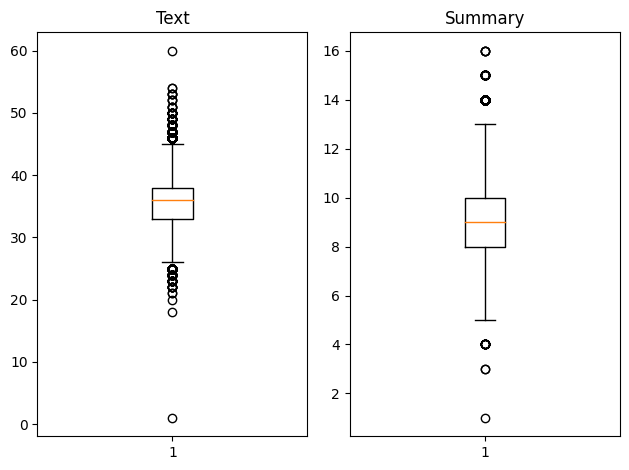

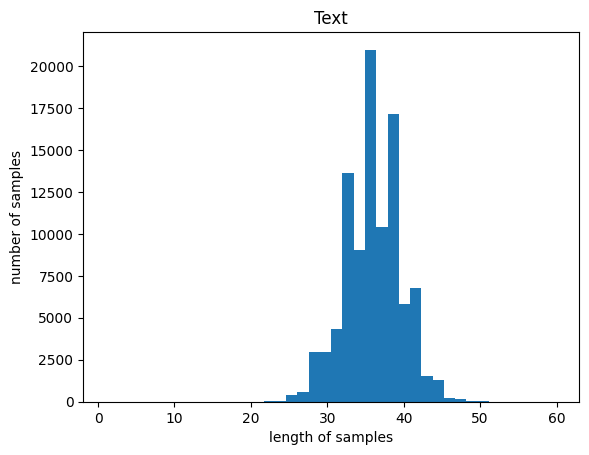

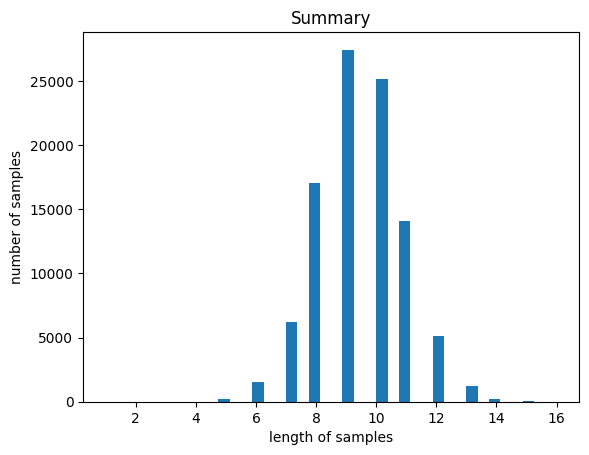

In [37]:
# 길이 분포 출력
import numpy as np
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in df_clean['Text']]
summary_len = [len(s.split()) for s in df_clean['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()
# 텍스트 또는 요약의 최소 길이가 1인 경우는 심각한 이상치로 판단 직접 확인이 필요하다고 생각

In [87]:
# 길이가 이상한 텍스트를 찾는 코드
text_length_1 = df_clean[df_clean['Text'].apply(lambda x: len(x.split()) <= 18)]
print("텍스트 길이가 이상한 항목:")
display(text_length_1)

# 길이가 이상한 요약을 찾는 코드
summary_length_1 = df_clean[df_clean['Summary'].apply(lambda x: len(x.split()) <= 3)]
print("요약 길이가 이상한 항목:")
display(summary_length_1)

#52번째 항목만 제외하면 된다는 것을 확인
df_clean.drop(52,inplace=True)

텍스트 길이가 이상한 항목:


,Text,Summary
52,text,headlines
19018,shahid kapoor said actor one always lonely adding always spotlight people see lonely actors emote inside throw said,as an actor you are always lonely shahid kapoor


요약 길이가 이상한 항목:


,Text,Summary
52,text,headlines
729,african nation angola decriminalised homosexuality parliament removed vices nature provision government also banned discrimination people basis sexual orientation changes come angola parliament adopted first new penal code since gained independence portugal 1975 removed provision,angola decriminalises homosexuality
26211,friggatriskaidekaphobia person irrational fear month 13th day falling friday long-standing legend claims day date unlucky number 13 considered unlucky many cultures least one friday 13th every year maximum three,what is friggatriskaidekaphobia


In [100]:
df_clean = df_clean.reset_index(drop=True)
# 길이가 이상한 텍스트를 찾는 코드
text_length_1 = df_clean[df_clean['Text'].apply(lambda x: len(x.split()) <= 18)]
print("텍스트 길이가 이상한 항목:")
display(text_length_1)

# 길이가 이상한 요약을 찾는 코드
summary_length_1 = df_clean[df_clean['Summary'].apply(lambda x: len(x.split()) <= 3)]
print("요약 길이가 이상한 항목:")
display(summary_length_1)

텍스트 길이가 이상한 항목:


,Text,Summary
19017,shahid kapoor said actor one always lonely adding always spotlight people see lonely actors emote inside throw said,as an actor you are always lonely shahid kapoor


요약 길이가 이상한 항목:


,Text,Summary
728,african nation angola decriminalised homosexuality parliament removed vices nature provision government also banned discrimination people basis sexual orientation changes come angola parliament adopted first new penal code since gained independence portugal 1975 removed provision,angola decriminalises homosexuality
26210,friggatriskaidekaphobia person irrational fear month 13th day falling friday long-standing legend claims day date unlucky number 13 considered unlucky many cultures least one friday 13th every year maximum three,what is friggatriskaidekaphobia


텍스트의 최소 길이 : 18
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.910633495663845
요약의 최소 길이 : 3
요약의 최대 길이 : 16
요약의 평균 길이 : 9.40425380493905


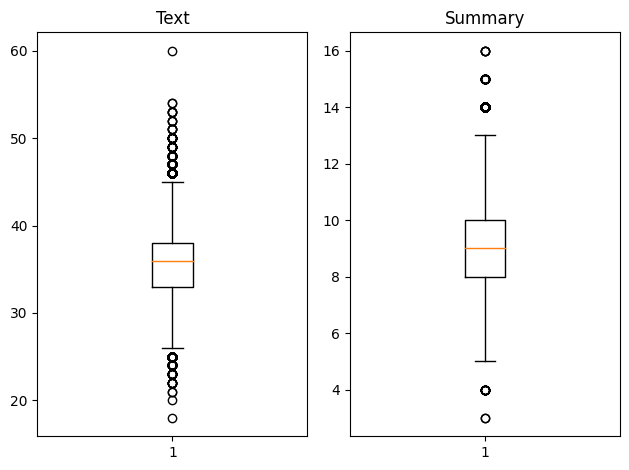

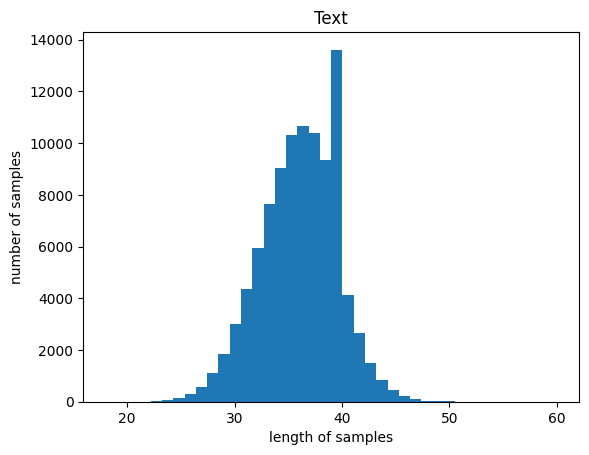

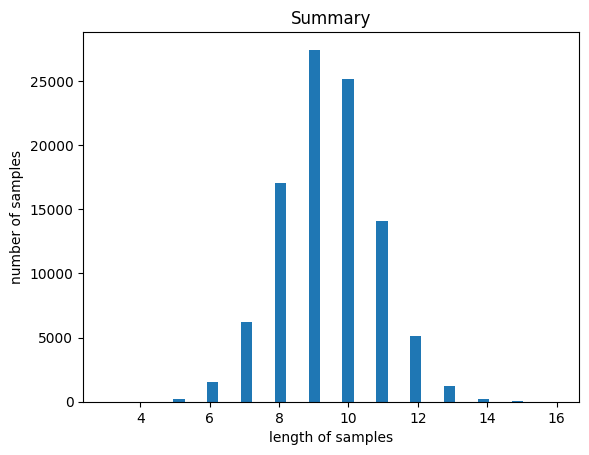

In [101]:
# 길이 분포 출력
import numpy as np
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in df_clean['Text']]
summary_len = [len(s.split()) for s in df_clean['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()
# 텍스트와 요약의 최대 길이가 그렇게 길지 않고 정규분포 형태를 보이므로 전체를 데이터셋으로 활용할 생각

In [109]:
text_max_len = 60
summary_max_len = 16

In [110]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
df_clean['decoder_input'] = df_clean['Summary'].apply(lambda x : 'sostoken '+ x)
df_clean['decoder_target'] = df_clean['Summary'].apply(lambda x : x + ' eostoken')
df_clean.head()

,Text,Summary,decoder_input,decoder_target
0,saurav kant alumnus upgrad iiit-b pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad 360-degree career support helped transition data scientist tech mahindra 90% salary hike upgrad online power learning powered lakh careers,upgrad learner switches to career in ml al with 90% salary hike,sostoken upgrad learner switches to career in ml al with 90% salary hike,upgrad learner switches to career in ml al with 90% salary hike eostoken
1,kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending 2000 cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit,delhi techie wins free food from swiggy for one year on cred,sostoken delhi techie wins free food from swiggy for one year on cred,delhi techie wins free food from swiggy for one year on cred eostoken
2,new zealand defeated india wickets fourth odi hamilton thursday win first match five-match odi series india lost international match rohit sharma captaincy 12 consecutive victories dating back march 2018 match witnessed india getting 92 seventh lowest total odi cricket history,new zealand end rohit sharma-led india 12-match winning streak,sostoken new zealand end rohit sharma-led india 12-match winning streak,new zealand end rohit sharma-led india 12-match winning streak eostoken
3,aegon life iterm insurance plan customers enjoy tax benefits premiums paid save 46 800 taxes plan provides life cover age 100 years also customers options insure critical illnesses disability accidental death benefit rider life cover age 80 years,aegon life iterm insurance plan helps customers save tax,sostoken aegon life iterm insurance plan helps customers save tax,aegon life iterm insurance plan helps customers save tax eostoken
4,speaking sexual harassment allegations rajkumar hirani sonam kapoor said known hirani many years not true metoo movement get derailed metoo movement always believe woman case need reserve judgment added hirani accused assistant worked sanju,have known hirani for yrs what if metoo claims are not true sonam,sostoken have known hirani for yrs what if metoo claims are not true sonam,have known hirani for yrs what if metoo claims are not true sonam eostoken


In [111]:
encoder_input = np.array(df_clean['Text']) # 인코더의 입력
decoder_input = np.array(df_clean['decoder_input']) # 디코더의 입력
decoder_target = np.array(df_clean['decoder_target']) # 디코더의 레이블

In [112]:
# 데이터 셔플링
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[92964 93906 46905 ... 14224 89537 21154]


In [113]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [114]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19671


In [115]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19671
테스트 레이블의 개수 : 19671


In [116]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성


In [117]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 72234
등장 빈도가 6번 이하인 희귀 단어의 수: 49155
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 23079
단어 집합에서 희귀 단어의 비율: 68.04967189965943
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.463492898710289


In [118]:
src_vocab = 23000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [119]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[730, 5152, 4725, 3159, 429, 158, 65, 7708, 793, 2017, 635, 611, 48, 1159, 296, 23, 5152, 4725, 1192, 4503, 135, 21522, 3944, 91, 4, 102, 101, 364, 5152, 9644, 5152, 363, 5152, 8048, 7, 3584, 518, 52], [28, 264, 104, 4135, 6494, 2247, 1560, 2248, 2747, 1342, 13438, 443, 210, 360, 163, 138, 2030, 212, 70, 6494, 2847, 1342, 331, 12690, 70, 1448, 1552, 211, 177, 81, 6841, 31, 617, 560, 5067, 35, 2747, 1144, 70], [5474, 595, 875, 840, 1293, 262, 321, 2848, 25, 3010, 323, 52, 132, 23, 3273, 627, 5474, 5908, 14279, 1007, 87, 2848, 1403, 2249, 27, 756, 8850, 21523, 2467, 1218, 84, 17345, 2572, 510, 510, 693, 5738, 4726, 71, 215, 567, 2106]]


In [120]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [121]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31991
등장 빈도가 5번 이하인 희귀 단어의 수: 21201
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10790
단어 집합에서 희귀 단어의 비율: 66.27176393360634
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.835649521480922


In [122]:
tar_vocab = 10800
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 3545, 1041, 1178, 216, 4, 53, 3, 133, 438, 3546, 4], [1, 5213, 4579, 252, 2450, 1250, 1691, 879], [1, 927, 624, 366, 2125, 3, 632, 1058, 150, 59, 296], [1, 13, 6726, 285, 603, 4, 4430, 4711, 1475, 13, 4712], [1, 249, 1237, 3, 918, 2318, 6, 1557, 7]]
target
decoder  [[3545, 1041, 1178, 216, 4, 53, 3, 133, 438, 3546, 4, 2], [5213, 4579, 252, 2450, 1250, 1691, 879, 2], [927, 624, 366, 2125, 3, 632, 1058, 150, 59, 296, 2], [13, 6726, 285, 603, 4, 4430, 4711, 1475, 13, 4712, 2], [249, 1237, 3, 918, 2318, 6, 1557, 7, 2]]


In [123]:
#전처리 과정에서 sostoken 혹은 eostoken만 남은 경우를 확인 => 없었음
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19671
테스트 레이블의 개수 : 19671


In [124]:
#지금 vocab의 size가 크기 때문에 cuDNN의 지원을 받기 위해 post로 처리, Attention 레이어도 쓰기 때문에 괜찮지 않을까?
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요.

 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

In [125]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

2025-02-09 21:42:56.115557: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-09 21:42:56.202529: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-09 21:42:56.202594: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-09 21:42:56.206979: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-09 21:42:56.207027: I tensorflow/compile

In [126]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [127]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 60, 128)              2944000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 60, 256),            394240    ['embedding[0][0]']           
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                              

In [128]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 60, 128)              2944000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 60, 256),            394240    ['embedding[0][0]']           
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                            

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history_1 = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)
#50에포크 동안 계속 val_loss가 낮아졌으므로 50에포크를 추가로 학습하기로 결정

Epoch 1/50


2025-02-09 21:44:14.358542: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3060" frequency: 1837 num_cores: 28 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 2359296 shared_memory_size_per_multiprocessor: 102400 memory_size: 10182721536 bandwidth: 360048000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2025-02-09 21:44:15.428934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-02-09 21:44:15.802160: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-0

308/308 [==============================] - ETA: 0s - loss: 4.7001

2025-02-09 21:44:49.152224: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3060" frequency: 1837 num_cores: 28 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 2359296 shared_memory_size_per_multiprocessor: 102400 memory_size: 10182721536 bandwidth: 360048000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


308/308 [==============================] - 40s 115ms/step - loss: 4.7001 - val_loss: 4.3955
Epoch 2/50
308/308 [==============================] - 29s 94ms/step - loss: 4.4147 - val_loss: 4.3345
Epoch 3/50
308/308 [==============================] - 27s 88ms/step - loss: 4.3400 - val_loss: 4.2568
Epoch 4/50
308/308 [==============================] - 28s 90ms/step - loss: 4.2628 - val_loss: 4.1757
Epoch 5/50
308/308 [==============================] - 27s 88ms/step - loss: 4.1426 - val_loss: 4.0373
Epoch 6/50
308/308 [==============================] - 27s 87ms/step - loss: 4.0202 - val_loss: 3.9502
Epoch 7/50
308/308 [==============================] - 27s 86ms/step - loss: 3.9387 - val_loss: 3.8940
Epoch 8/50
308/308 [==============================] - 27s 86ms/step - loss: 3.8706 - val_loss: 3.8476
Epoch 9/50
308/308 [==============================] - 26s 86ms/step - loss: 3.8010 - val_loss: 3.7699
Epoch 10/50
308/308 [==============================] - 27s 86ms/step - loss: 3.7410 - val_lo

In [ ]:
plt.plot(history_1.history['loss'], label='train')
plt.plot(history_1.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# 이어서 학습할 때에는 patience를 5로 설정하여 조금 더 학습할 수 있도록 환경 개선
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history_2 = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 26s 85ms/step - loss: 2.4065 - val_loss: 2.9779
Epoch 2/50
308/308 [==============================] - 26s 85ms/step - loss: 2.3884 - val_loss: 2.9784
Epoch 3/50
308/308 [==============================] - 27s 86ms/step - loss: 2.3708 - val_loss: 2.9711
Epoch 4/50
308/308 [==============================] - 27s 87ms/step - loss: 2.3538 - val_loss: 2.9665
Epoch 5/50
308/308 [==============================] - 27s 86ms/step - loss: 2.3371 - val_loss: 2.9617
Epoch 6/50
308/308 [==============================] - 27s 86ms/step - loss: 2.3199 - val_loss: 2.9659
Epoch 7/50
308/308 [==============================] - 27s 86ms/step - loss: 2.3050 - val_loss: 2.9599
Epoch 8/50
308/308 [==============================] - 27s 86ms/step - loss: 2.2888 - val_loss: 2.9561
Epoch 9/50
308/308 [==============================] - 27s 86ms/step - loss: 2.2725 - val_loss: 2.9553
Epoch 10/50
308/308 [==============================] - 27s 87ms/step - loss: 2.258

In [ ]:
plt.plot(history_2.history['loss'], label='train')
plt.plot(history_2.history['val_loss'], label='test')
plt.legend()
plt.show()

Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [136]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [137]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [138]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [139]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [140]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for idx in input_seq:
        if (idx != 0) and (idx != tar_tokenizer.word_index['sostoken']) and (idx != tar_tokenizer.word_index['eostoken']):
            temp = temp + tar_index_to_word[idx] + ' '
    return temp


In [142]:
raw_data=[]
raw_summary=[]
predict_summary=[]

for i in range(50, 100):
    raw_data.append(seq2text(encoder_input_test[i]))
    raw_summary.append(seq2text(decoder_input_test[i]))
    predict_summary.append(decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))

1/1 [==============================] - 0s 15ms/step


In [148]:
for i in range(0, 5):
    print("전처리된 원문 :", raw_data[i])
    print("실제 요약 :", raw_summary[i])
    print("예측 요약 :", predict_summary[i])
    print("\n")

전처리된 원문 : fifty nations wednesday signed treaty banning use nuclear weapons amid opposition nuclear armed countries legally binding treaty provides total ban developing stockpiling threatening use nuclear weapons circumstances come effect 90 days 50 nations 
실제 요약 : said filed fifth important back confidential 1996 secretary register 
예측 요약 :  un rejects myanmar military drills over anti nuclear crisis


전처리된 원문 : scientists pune based national institute spotted new genetic variant existing dengue virus tamil nadu 1 virus responsible tamil nadu 2012 kerala 2013 scientists said mosquito borne virus said entered india singapore associated severe 2005 
실제 요약 : said delhi 40 eclipse congress hiv onto year games bangladesh 
예측 요약 :  new zealand to be held for zika in kerala


전처리된 원문 : virat kohli become first ever batsman hit 500 plus runs bilateral odi series achieving feat sixth odi south africa friday previously record runs series held rohit sharma smashed runs australia 2013 kohli also

### 전처리된 내용을 제공하고 해당 내용을 16단어 이하로 요약하라는 요청을 Deepseek-R1에게 요청해보았습니다.

1. fifty nations wednesday signed treaty banning use nuclear weapons amid opposition nuclear armed countries legally binding treaty provides total ban developing stockpiling threatening use nuclear weapons circumstances come effect 90 days 50 nations 

    - Deepseek : 50 nations sign treaty banning nuclear weapons, effective in 90 days despite opposition.

    - 학습시킨 모델 : un rejects myanmar military drills over anti nuclear crisis

2. scientists pune based national institute spotted new genetic variant existing dengue virus tamil nadu 1 virus responsible tamil nadu 2012 kerala 2013 scientists said mosquito borne virus said entered india singapore associated severe 2005

    - Deepseek : Indian scientists identify new dengue variant linked to severe cases from Singapore.

    - 학습시킨 모델 : new zealand to be held for zika in kerala

3. virat kohli become first ever batsman hit 500 plus runs bilateral odi series achieving feat sixth odi south africa friday previously record runs series held rohit sharma smashed runs australia 2013 kohli also became fastest reach 17 000 international runs

    - Deepseek : Virat Kohli first to score 500+ runs in bilateral ODI series, breaks records.

    - 학습시킨 모델 : virat kohli becomes fastest odi to slam odi odi


4. raveena tandon slammed media house publishing report fir filed allegedly shooting advertisement inside temple open eyes wake look around get facts right tweeted earlier official advertising agency clarified not shooting temple premises

    - Deepseek : Raveena Tandon slams media over false temple shoot allegation, agency clarifies.

    - 학습시킨 모델 : kannada actor accused of sexual harassment at temple

5. spanish clothing brand zara introduced skirt priced 70 twitter user commented cannot serious zara trying sell dad lungi 70 dad lungi probably cheaper pounds wrote another user meanwhile another comment read get dad one free


    - Deepseek : Zara's £70 skirt mocked as overpriced "dad lungi" on social media.

    - 학습시킨 모델 : fashion brand trolled for fake old company

둘이 요약한 모습을 살펴보았을 때 둘의 차이점을 정리해보았습니다.
1. 요약 시, 제가 학습한 모델은 숫자 토큰을 활용했음에도 출력물에는 나오지 않는 모습을 확인할 수 있습니다.

2. 전처리의 편의상 특수문자를 없애는 방향으로 학습시켰지만, Deepseek에서는 문장에 특수문자가 없어도 출력해내는 모습을 보입니다.

3. Deepseek는 odi series를 ODI seires로 odi가 약어임을 파악한 모습을 확인할 수 있습니다.

### 실제 원문의 내용을 확인해보고 Deepseek-R1에게 16단어를 이하로 내용을 요약해주라고 요청해보았습니다.
1. Fifty nations on Wednesday signed a treaty banning the use of nuclear weapons amid opposition by nuclear-armed countries. The legally-binding treaty provides for a total ban on developing, stockpiling or threatening to use nuclear weapons "under any circumstances". It will come into effect 90 days after it is ratified by 50 nations.

    - 요약 : Fifty nations signed a treaty banning nuclear weapons, opposed by nuclear-armed states, effective after 50 ratifications.

2. Scientists at Pune-based National Institute of Virology have spotted a new genetic variant of the existing dengue virus in Tamil Nadu. The DENV-1 virus was responsible for outbreaks in Tamil Nadu in 2012 and Kerala in 2013, scientists said. The mosquito-borne virus is said to have entered into India from Singapore, where it was associated with severe epidemics in 2005.

    - 요약 : Pune scientists identified a new dengue virus strain (DENV-1) in Tamil Nadu, linked to 2012–13 outbreaks and Singapore origins.

3. Virat Kohli has become the first-ever batsman to hit 500-plus runs in a bilateral ODI series, achieving the feat in the sixth ODI against South Africa on Friday. Previously, the record for most runs in a series was held by Rohit Sharma, who smashed 491 runs against Australia in 2013. Kohli also became the fastest to reach 17,000 international runs.

    - 요약 : Virat Kohli broke records with 500+ ODI runs in a bilateral series (vs South Africa) and fastest to 17k international runs.

4. Actress Shilpa Shetty, Sridevi and Raveena Tandon took to social media to share pictures as they celebrated the festival of Karva Chauth together on Sunday. The celebration was hosted by Anil Kapoor's wife Sunita Kapoor at their residence. "A Good behaviour is pass횄짤 when you are fasting (starving)," wrote Shilpa while sharing wishes on the occasion via a video.

    - 요약 : Shilpa Shetty, Sridevi, and Raveena Tandon celebrated Karva Chauth at Anil Kapoor’s residence, sharing social media posts.

5. After Spanish clothing brand Zara introduced a skirt priced at 횂짙70 (창혗쨔6,000), a Twitter user commented, "You can't be serious. Zara is trying to sell your dad's 횂짙3 lungi for 횂짙70." "My dad's lungi is probably cheaper than 3 pounds," wrote another user. Meanwhile, another comment read, "I'll just get my dad's one from his cupboard for free."

    - 요약 : Zara faced ridicule for a £70 skirt resembling a lungi, sparking viral Twitter comparisons to cheaper traditional attire.

Step 5. Summa을 이용해서 추출적 요약해보기

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 

반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [ ]:
from summa import summarizer

real_text = [
    'Fifty nations on Wednesday signed a treaty banning the use of nuclear weapons amid opposition by nuclear-armed countries. The legally-binding treaty provides for a total ban on developing, stockpiling or threatening to use nuclear weapons "under any circumstances". It will come into effect 90 days after it is ratified by 50 nations.',
    'Scientists at Pune-based National Institute of Virology have spotted a new genetic variant of the existing dengue virus in Tamil Nadu. The DENV-1 virus was responsible for outbreaks in Tamil Nadu in 2012 and Kerala in 2013, scientists said. The mosquito-borne virus is said to have entered into India from Singapore, where it was associated with severe epidemics in 2005.',
    'Virat Kohli has become the first-ever batsman to hit 500-plus runs in a bilateral ODI series, achieving the feat in the sixth ODI against South Africa on Friday. Previously, the record for most runs in a series was held by Rohit Sharma, who smashed 491 runs against Australia in 2013. Kohli also became the fastest to reach 17,000 international runs.',
    'Actress Shilpa Shetty, Sridevi and Raveena Tandon took to social media to share pictures as they celebrated the festival of Karva Chauth together on Sunday. The celebration was hosted by Anil Kapoor\'s wife Sunita Kapoor at their residence. "A Good behaviour is pass횄짤 when you are fasting (starving)," wrote Shilpa while sharing wishes on the occasion via a video.',
    'After Spanish clothing brand Zara introduced a skirt priced at 횂짙70 (창혗쨔6,000), a Twitter user commented, "You can\'t be serious. Zara is trying to sell your dad\'s 횂짙3 lungi for 횂짙70." "My dad\'s lungi is probably cheaper than 3 pounds," wrote another user. Meanwhile, another comment read, "I\'ll just get my dad\'s one from his cupboard for free."'
]

# Summa로 추출적 요약을 생성
summa_summaries = []
for text in real_text:
    summa_summary = summarizer.summarize(text)

print(summa_summaries)
#하나도 요약하지 못하는 모습..


[]


In [ ]:
text = """Automatic summarization is the process of reducing a text document with a
computer program in order to create a summary that retains the most important points
of the original document. As the problem of information overload has grown, and as
the quantity of data has increased, so has interest in automatic summarization.
Technologies that can make a coherent summary take into account variables such as
length, writing style and syntax. An example of the use of summarization technology
is search engines such as Google. Document summarization is another."""

summarizer.summarize(text)
#문장이 더 많이 길어야 요약해주는 것을 확인

'Automatic summarization is the process of reducing a text document with a\nDocument summarization is another.'

In [172]:
#chatgpt에게 문장을 늘려달라고 요청 
import json

with open("summa_text.json", "r", encoding="utf-8") as file:
    real_text = json.load(file)["real_text"]

gpt_summaries = []
summa_summaries = []

for idx in range(len(real_text)):
    gpt_summaries.append(real_text[idx]['title'])
    summa_summaries.append(summarizer.summarize(real_text[idx]["content"]))

In [174]:
for i in range(0, 5):
    print('GPT 요약 : ', gpt_summaries[i])
    print('추출적 요약 : ', summa_summaries[i])
    print("\n")

GPT 요약 :  Nuclear Weapons Ban Treaty Signed by 50 Nations
추출적 요약 :  However, the treaty has faced strong opposition from nuclear-armed nations, which argue that such a ban is impractical without a structured process for phased disarmament.


GPT 요약 :  New Dengue Virus Variant Discovered in India
추출적 요약 :  Given the increasing frequency of dengue outbreaks in India, health officials are now monitoring the spread of this new variant closely, emphasizing the need for improved vector control measures, early detection systems, and vaccine research to combat the evolving threats posed by the virus.


GPT 요약 :  Virat Kohli Sets New Record in ODI Cricket
추출적 요약 :  Indian cricket captain Virat Kohli has once again proven his dominance in international cricket by becoming the first-ever batsman to score over 500 runs in a bilateral One Day International (ODI) series.


GPT 요약 :  Bollywood Celebrities Celebrate Karva Chauth
추출적 요약 :  Bollywood actresses Shilpa Shetty, Sridevi, and Raveena Tandon 

In [178]:
import language_tool_python #문법검사기
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

tool = language_tool_python.LanguageTool('en-US')

def count_grammar_errors(text):
    """
    주어진 텍스트의 문법 오류 개수를 반환합니다.
    오류가 적을수록 문법 완성도가 높다고 평가할 수 있습니다.
    """
    matches = tool.check(text)
    return len(matches)

def extract_keywords(text):
    """
    텍스트에서 불용어(stopwords)를 제외한 알파벳 단어들을 추출하여 집합으로 반환합니다.
    이를 통해 핵심 단어의 포함 정도를 평가할 수 있습니다.
    """
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    keywords = [word for word in tokens if word not in stop_words]
    return set(keywords)

In [180]:
nltk.download('punkt', quiet=True)

# 각 기사별로 두 요약 방법의 평가 결과를 저장할 리스트
comparison_results = []

for idx, entry in enumerate(real_text):
    # 문법 완성도 평가: 문법 오류 개수를 측정 (오류 수가 적을수록 좋음)
    gpt_errors = count_grammar_errors(gpt_summaries[idx])
    summa_errors = count_grammar_errors(summa_summaries[idx])
    
    # 핵심 단어 포함 평가: 원본 content에서 추출한 키워드와 요약본에 포함된 키워드의 교집합을 계산
    reference_keywords = extract_keywords(entry["content"])
    gpt_summary_keywords = extract_keywords(gpt_summaries[idx])
    summa_summary_keywords = extract_keywords(summa_summaries[idx])
    
    gpt_keyword_match = len(reference_keywords.intersection(gpt_summary_keywords))
    summa_keyword_match = len(reference_keywords.intersection(summa_summary_keywords))
    
    comparison_results.append({
        "title": gpt_summaries[idx],
        "gpt_grammar_errors": gpt_errors,
        "summa_grammar_errors": summa_errors,
        "gpt_keyword_matches": gpt_keyword_match,
        "summa_keyword_matches": summa_keyword_match
    })

In [ ]:
# 평가 결과를 표 형식으로 출력
print("{:<20} {:<20} {:<20}".format("평가 항목", "GPT 요약 (추상적)", "Extractive 요약 (Summa)"))
print("-" * 120)
for result in comparison_results:
    print("제목: {}".format(result["title"]))
    print("{:<30}: {:<10}    {:<10}".format("문법 오류 수", result["gpt_grammar_errors"], result["summa_grammar_errors"]))
    print("{:<30}: {:<10}    {:<10}".format("핵심 단어 포함 수", result["gpt_keyword_matches"], result["summa_keyword_matches"]))
    print("-" * 120)

#추출적 요약의 경우 문장의 길이가 긴 만큼 핵심 단어를 더 많이 포함할 수 있었지만, 문법 오류가 더 많은 것을 확인할 수 있음. 그 이유는 아마 GPT로 생성한 문장이기 때문이지 않을까 하는 생각이 듦
#추상적 요약의 경우 문장이 짧은 만큼 문법 오류의 수가 적은 것을 확인할 수 있음. 오히려 GPT가 생성한 문장에 문법 오류를 찾아내는 tool = language_tool_python.LanguageTool('en-US')이게 더 신기함

평가 항목                GPT 요약 (추상적)         Extractive 요약 (Summa)
------------------------------------------------------------------------------------------------------------------------
제목: Nuclear Weapons Ban Treaty Signed by 50 Nations
문법 오류 수                       : 0             0         
핵심 단어 포함 수                    : 5             14        
------------------------------------------------------------------------------------------------------------------------
제목: New Dengue Virus Variant Discovered in India
문법 오류 수                       : 0             0         
핵심 단어 포함 수                    : 5             29        
------------------------------------------------------------------------------------------------------------------------
제목: Virat Kohli Sets New Record in ODI Cricket
문법 오류 수                       : 0             1         
핵심 단어 포함 수                    : 6             17        
-----------------------------------------------------------------------------------

## 회고

1. 처음 시작할 때에는 AI-Driven과 같이 '-'가 들어가거나 '%'가 들어간 토큰을 살리고 싶었으나, 후반부에 vocab 구성 시 드물게 등장하는 단어를 제거하면서 같이 사라진 부분을 확인할 수 있었다. 전체 데이터셋을 활용하여 학습을 진행시키고 싶었지만 vocab의 크기가 커지면 임베딩 레이어 학습 시, 나의 GPU인 RTX 3060이 적절히 처리하지 못할 것을 우려하여 삭제하였다. 이 때, 좀 더 정확한 계산식을 알 수 있다면 그 크기에 맞춰 고려할 수 있었을텐데 하는 아쉬움 남았으며,

2. 출력된 요약 내용을 확인했을 때도 알 수 있듯이, 숫자를 분명 토큰으로 넣었지만 특수 문자와 마찬가지로 모든 숫자가 토큰으로 반영되지 않은 것을 알 수 있었습니다. 이를 통해 등장 빈도를 고려하여 토큰을 제거하는게 합리적인 방식인지 의문이 갔고 vocab의 적절한 크기에 대해 고민한 논문 (Finding the Optimal Vocabulary Size for Neural Machine Translation)(https://arxiv.org/abs/2004.02334), 단어 단위로 토큰화를 하는 것이 아닌 바이트 단위로 토큰화 하는 방법 (Byte Pair Encoding)(https://process-mining.tistory.com/189) 등을 확인할 수 있었다.

평가문항	상세기준

1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.	분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.

2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.	모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다.

3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.	두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.